In [3]:
# Always a bit risky, but I think the chance for name space convolution is small 
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy as sp
import os
import matplotlib.pyplot as plt
from plotnine import *
import warnings
warnings.filterwarnings("ignore")


# A nice color palette for categorical data 
cbPalette = ["#E69F00", "#56B4E9", "#009E73", 
             "#0072B2", "#D55E00", 
             "#CC79A7", "#F0E442", "#999999"]

col_highlight = ["#D0C0B0", "#0A3D6B", "#B6C2CC", "#BEAAB4", "#ECE9CD", "#0D5C3D", "#812F02"]

# Proportions when saving figures 
BASE_HEIGHT = 5
BASE_WIDTH = 7.0

# Directory for saving figures
dir_save = "./Figs/"
if not os.path.isdir(dir_save):
    os.mkdir(dir_save)


## Spatial data - lets talk about maps

It is always important to keep the projection in question. Below (albeit not optimal) WSG84 is the best because it produces the smallest overestimation of to what degree the world is covered by forest.

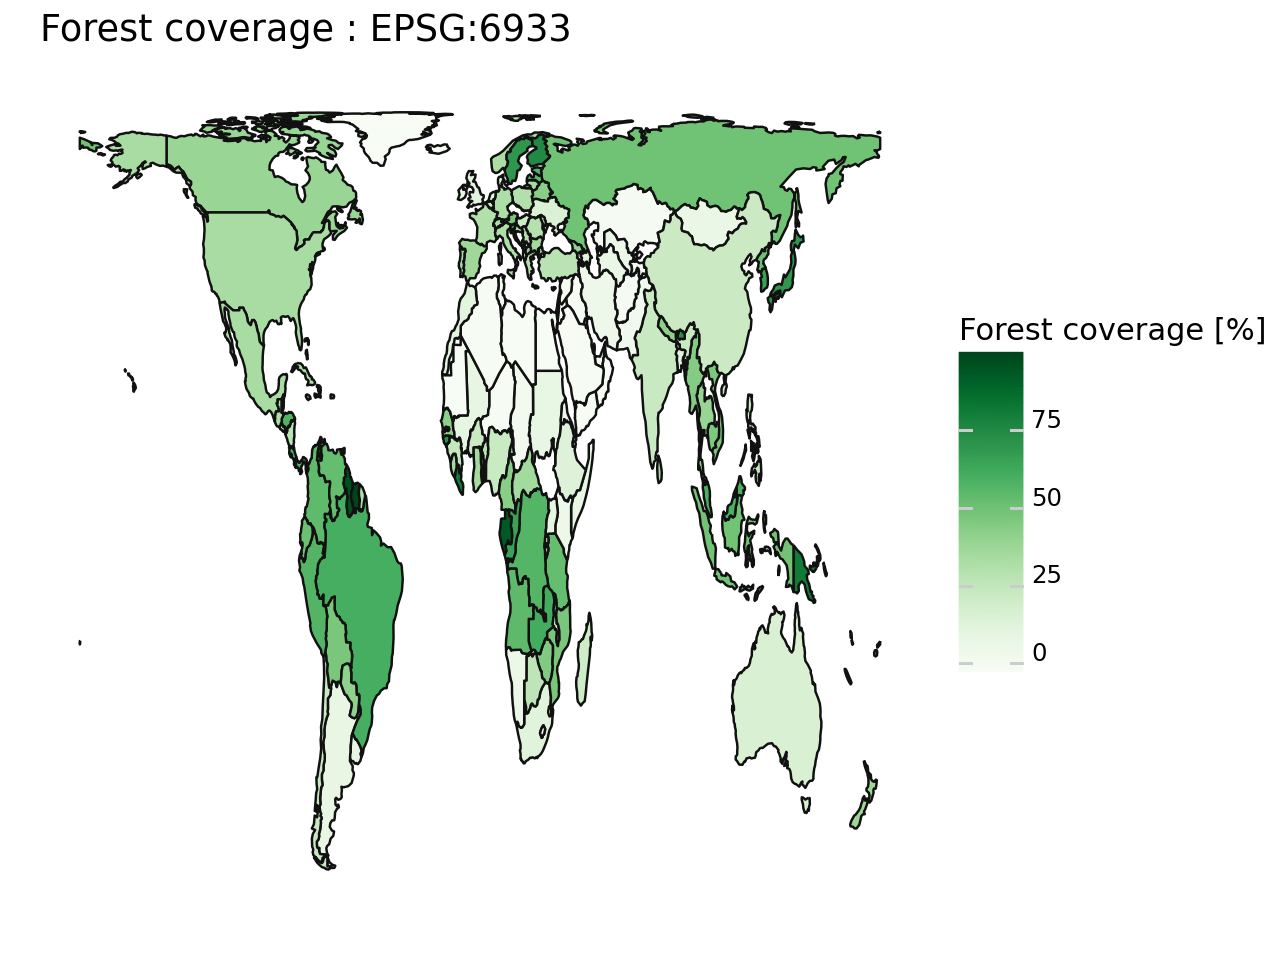

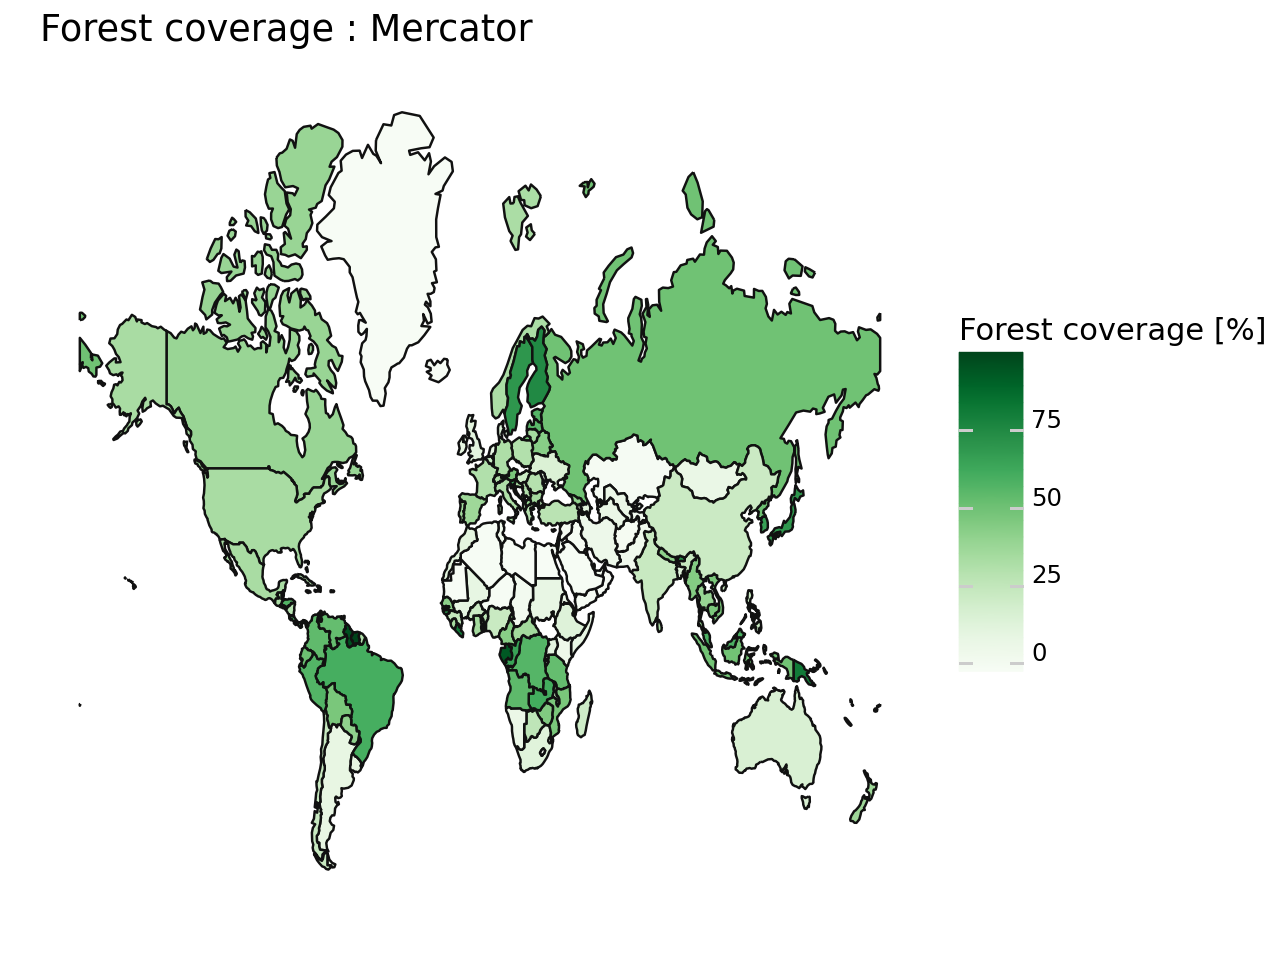

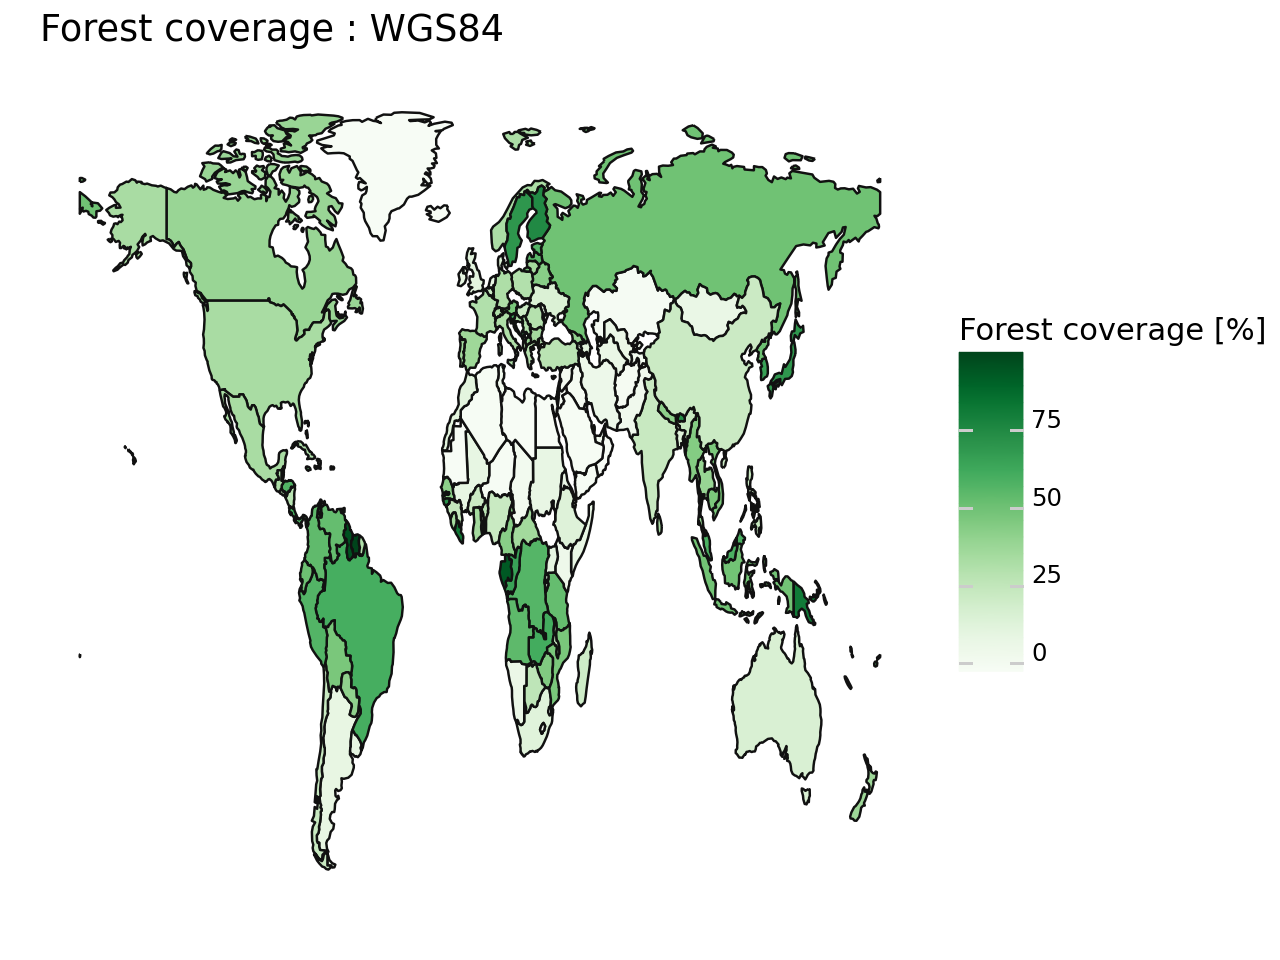

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [4]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
data_forest = pd.read_csv("Data/Forest_tidy.csv")

# EPSG:6933
world_lambert = world.to_crs("EPSG:6933")
data_world_forest = world_lambert.merge(data_forest, left_on="name", right_on="Country")
p1 = (ggplot(data_world_forest, aes(fill="2019_forest"))
    + geom_map()
    + labs(title="Forest coverage : EPSG:6933")
    + scale_fill_cmap("Greens", name = "Forest coverage [%]") 
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

# Mercator
world_mercator = world.to_crs("EPSG:3395")
data_world_forest = world_mercator.merge(data_forest, left_on="name", right_on="Country")
p2 = (ggplot(data_world_forest, aes(fill="2019_forest"))
    + geom_map()
    + labs(title="Forest coverage : Mercator")
    + scale_fill_cmap("Greens", name = "Forest coverage [%]")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

# EPSG:4326
world_wsg84 = world.to_crs("EPSG:4326")
data_world_forest = world_wsg84.merge(data_forest, left_on="name", right_on="Country")
p3 = (ggplot(data_world_forest, aes(fill="2019_forest"))
    + geom_map()
    + labs(title="Forest coverage : WGS84")
    + scale_fill_cmap("Greens", name = "Forest coverage [%]")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p1.save("Figs/Maps_forest_lambert.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Maps_forest_mercator.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p3.save("Figs/Maps_forest_WSG84.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)

[p1, p2, p3]

When working with coloured maps, always use a sufficient resolution. For example, when plotting Sweden's population, I would go for municipals instead of Län. 

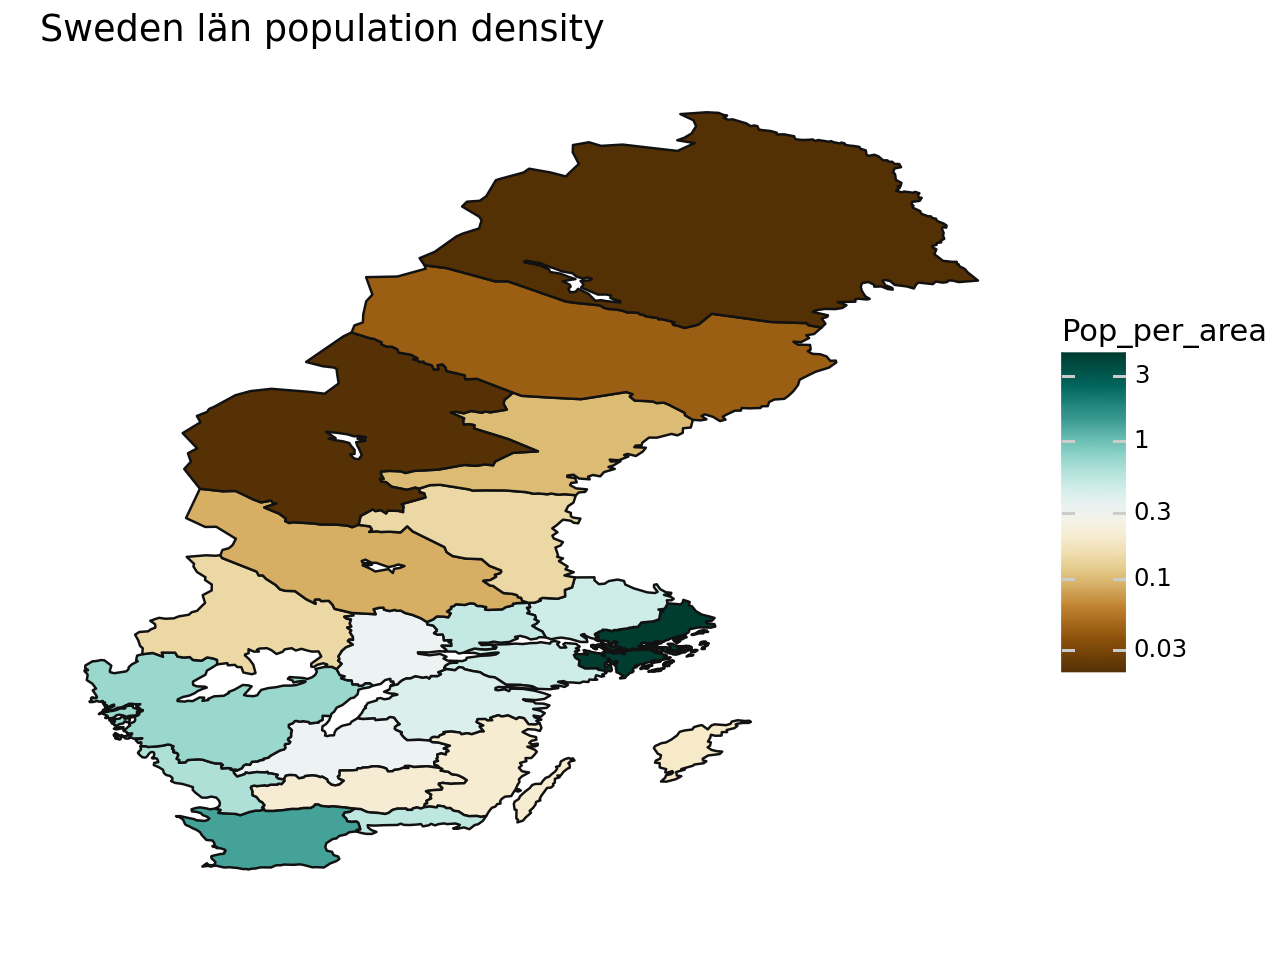

<Figure Size: (640 x 480)>

In [5]:
swe = gpd.read_file("Data/Lan_Sweref99TM_region.shp")
data_pop = pd.read_csv("Data/Swe_pop_län_2021.csv")

swe["LnKod"] = swe["LnKod"].apply(str)
data_pop["Region_number"] = data_pop["Region_number"].apply(str)

data_pop_plot = swe.merge(data_pop, left_on="LnNamn", right_on="Region")
data_pop_plot["Pop_per_area"] = data_pop_plot["Population"] / data_pop_plot["geometry"].area * 1e4

p = (ggplot(data_pop_plot)
    + geom_map(aes(fill = "Pop_per_area"))
    + scale_fill_cmap("BrBG", trans="log10")
    + labs(title = "Sweden län population density")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p.save("Figs/Sweden_lan.png", width=BASE_WIDTH, height=BASE_HEIGHT*1.5, dpi=300)
p

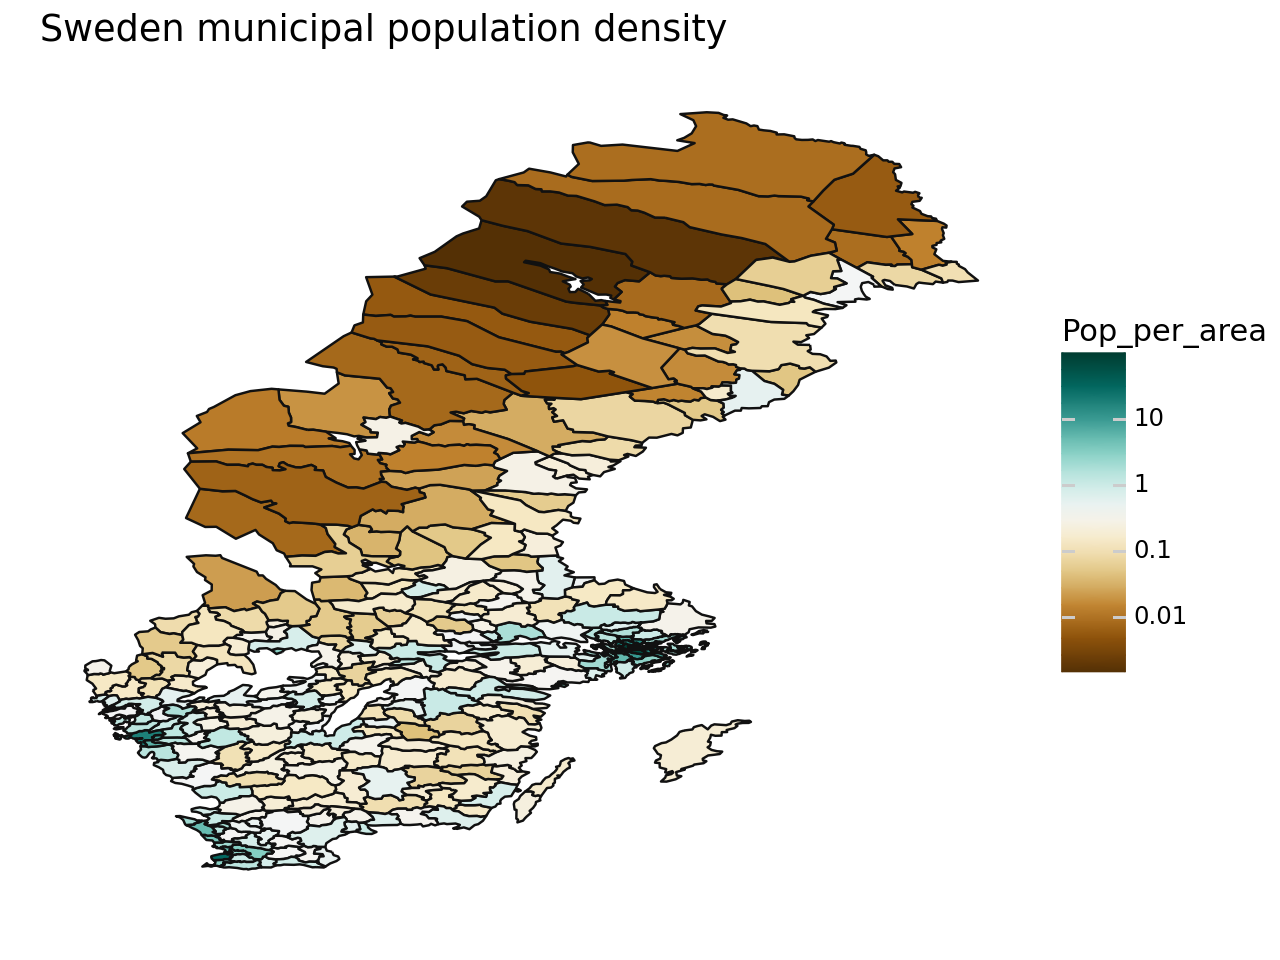

<Figure Size: (640 x 480)>

In [6]:
swe = gpd.read_file("Data/Kommun_Sweref99TM_region.shp")

data_pop = pd.read_csv("Data/Swe_pop_2021.csv")
data_pop_plot = swe.merge(data_pop, left_on="KnNamn", right_on="Municipal")
data_pop_plot["Pop_per_area"] = data_pop_plot["Population"] / data_pop_plot["geometry"].area * 1e4

p = (ggplot(data_pop_plot)
    + geom_map(aes(fill = "Pop_per_area"))
    + scale_fill_cmap("BrBG", trans="log10")
    + labs(title = "Sweden municipal population density")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p.save("Figs/Sweden_municipial.png", width=BASE_WIDTH, height=BASE_HEIGHT*1.5, dpi=300)
p

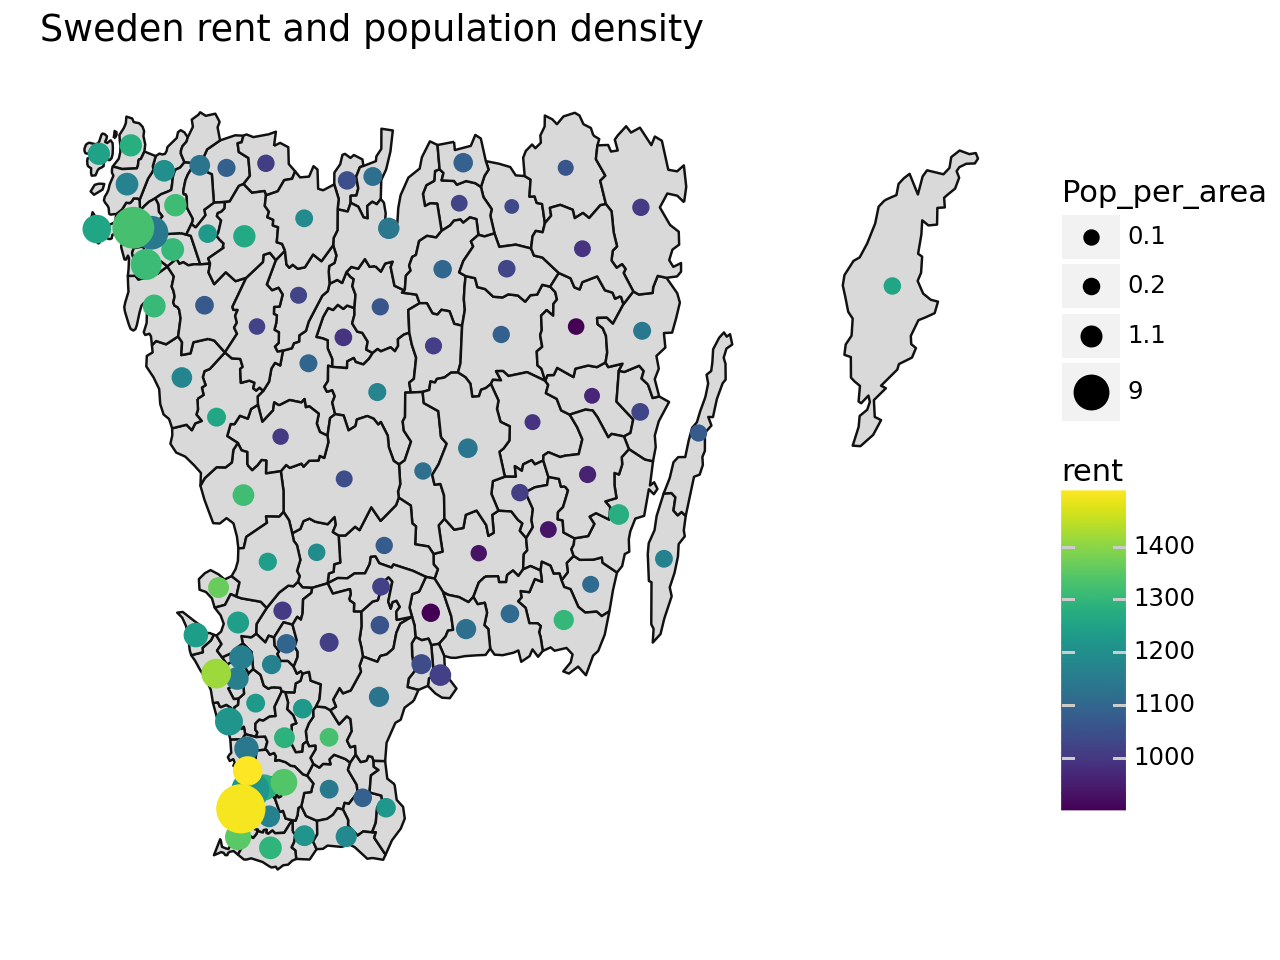

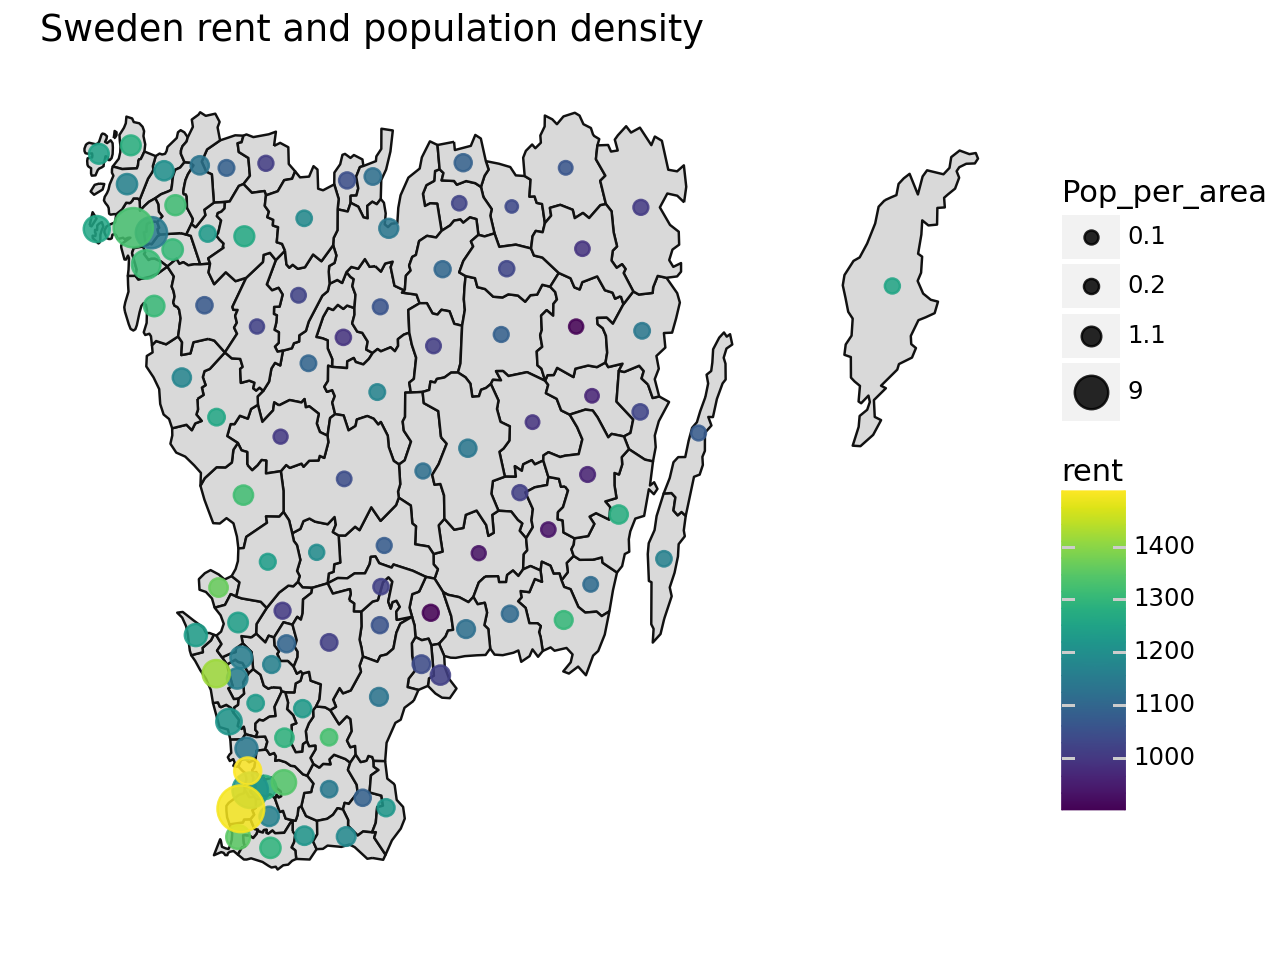

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [7]:
# Let us focus on southern Sweden
swe = gpd.read_file("Data/Kommun_Sweref99TM_region.shp")

data_pop = pd.read_csv("Data/Municipial_rent.csv")
data_pop_plot = swe.merge(data_pop, left_on="KnNamn", right_on="Municipal")
data_pop_plot["Pop_per_area"] = data_pop_plot["Population"] / data_pop_plot["geometry"].area * 1e4
data_pop_plot["x"] = data_pop_plot["geometry"].centroid.map(lambda p: p.x)
data_pop_plot["y"] = data_pop_plot["geometry"].centroid.map(lambda p: p.y)
data_pop_plot = data_pop_plot[data_pop_plot["y"] < 6443029]

p1 = (ggplot(data_pop_plot)
    + geom_map(fill="#d9d9d9")
    + geom_point(aes(x="x", y="y", size="Pop_per_area", color="rent"), alpha=1.0)
    + labs(title = "Sweden rent and population density", x = "", y = "")
    + scale_size_continuous(range = (2, 9), breaks=[0.1, 0.2, 1.1, 9.0])
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))
p2 = (ggplot(data_pop_plot)
    + geom_map(fill="#d9d9d9")
    + geom_point(aes(x="x", y="y", size="Pop_per_area", color="rent"), alpha=0.85)
    + labs(title = "Sweden rent and population density", x = "", y = "")
    + scale_size_continuous(range = (2, 9), breaks=[0.1, 0.2, 1.1, 9.0])
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p1.save("Figs/Sweden_municipial_rent1.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Sweden_municipial_rent2.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)

[p1, p2]

To continue on the topic of how to low resolution with a colour-based map is not ideal, let us consider Starbucks. 

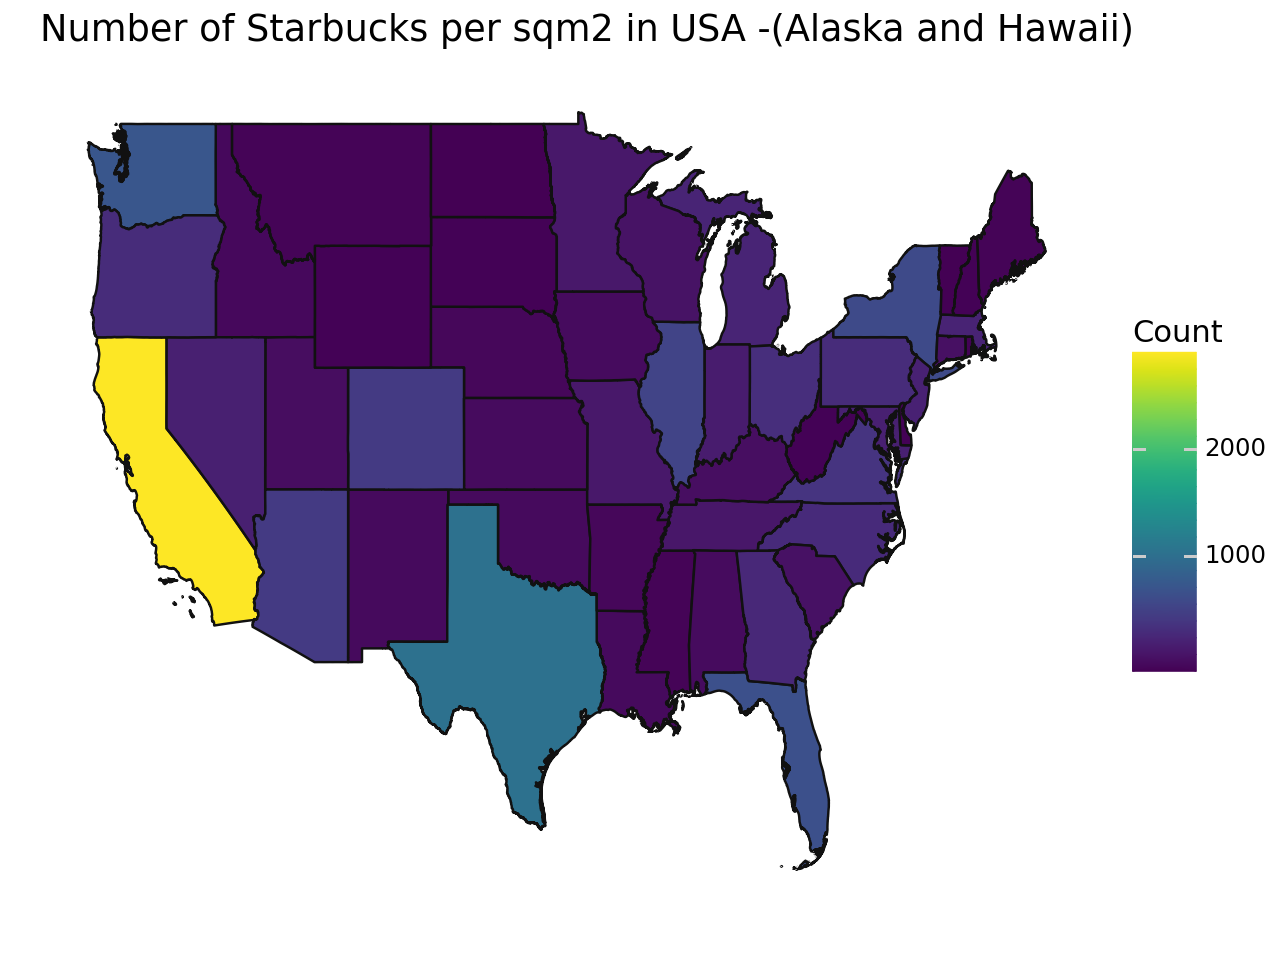

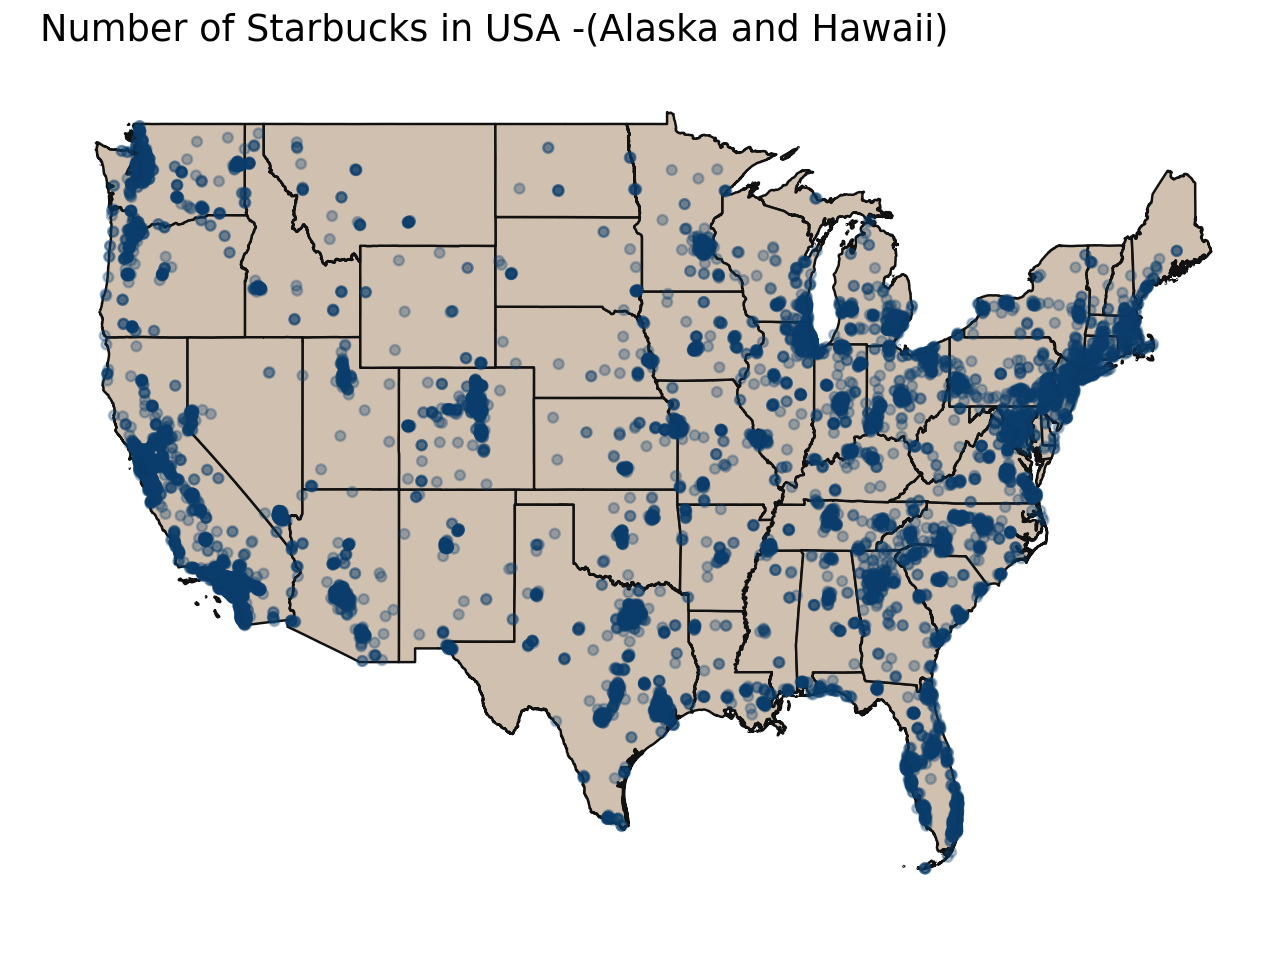

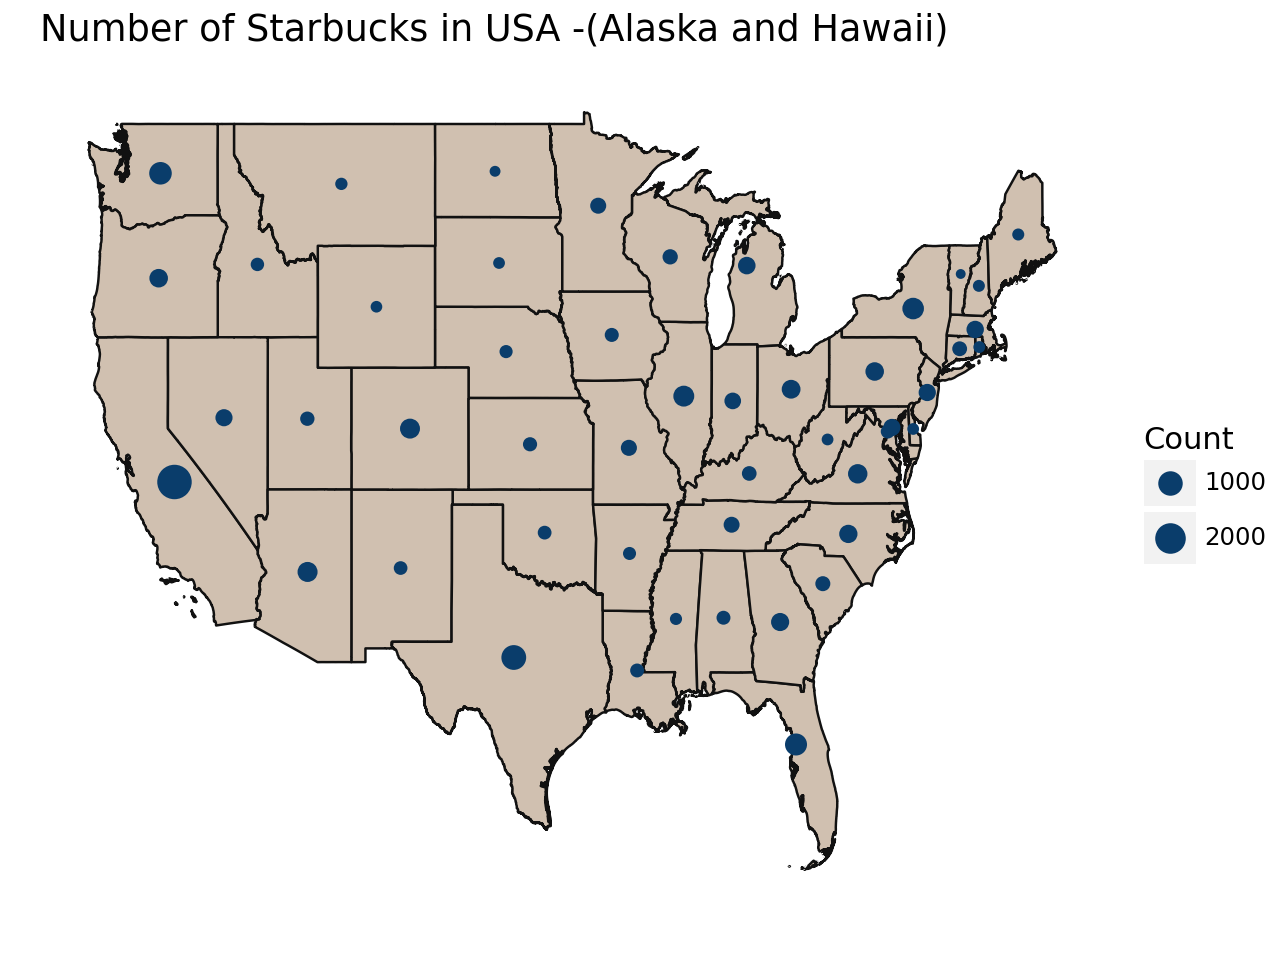

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [8]:
map_USA = gpd.read_file("Data/cb_2018_us_state_500k.shp")

starbucks_stores = pd.read_csv("Data/Startbucks_location.csv")
us_stores = starbucks_stores[starbucks_stores.Country=="US"]

# Remove non-mainland terratories (+ Alaska)
us_stores = us_stores.loc[us_stores["State/Province"] != "VI"]
us_stores = us_stores.loc[us_stores["State/Province"] != "MP"]
us_stores = us_stores.loc[us_stores["State/Province"] != "GU"]
us_stores = us_stores.loc[us_stores["State/Province"] != "HI"]
us_stores = us_stores.loc[us_stores["State/Province"] != "AK"]

# Prepare dataframe
us_stores_statewise_tmp = us_stores.groupby("State/Province").count()[["Store Name"]].rename(columns={"Store Name":"Count"})
us_stores_statewise_tmp = us_stores_statewise_tmp.reset_index()
us_stores_statewise =  map_USA.merge(us_stores_statewise_tmp, left_on="STUSPS", right_on="State/Province")

us_stores_statewise["Count_norm"] = us_stores_statewise["Count"] / us_stores_statewise["geometry"].area 

p1 = (ggplot(us_stores_statewise)
    + geom_map(aes(fill="Count"))
    + labs(title = "Number of Starbucks per sqm2 in USA -(Alaska and Hawaii)")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p2 = (ggplot(us_stores_statewise)
    + geom_map(fill=col_highlight[0])
    + geom_point(data=us_stores, mapping=aes(x="Longitude", y="Latitude"), color=col_highlight[1], alpha=0.3)
    + labs(title = "Number of Starbucks in USA -(Alaska and Hawaii)")
    + labs(x = "", y = "")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

us_stores_statewise["x"] = us_stores_statewise["geometry"].centroid.map(lambda p: p.x)
us_stores_statewise["y"] = us_stores_statewise["geometry"].centroid.map(lambda p: p.y)
p3 = (ggplot(us_stores_statewise)
    + geom_map(fill=col_highlight[0])
    + geom_point(aes(x="x", y="y", size="Count"), color=col_highlight[1])
    + labs(title = "Number of Starbucks in USA -(Alaska and Hawaii)")
    + labs(x = "", y = "")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))


p1.save("Figs/Starbucks1.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p2.save("Figs/Starbuck2.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)

# Homework - Asian market
[p1, p2, p3]


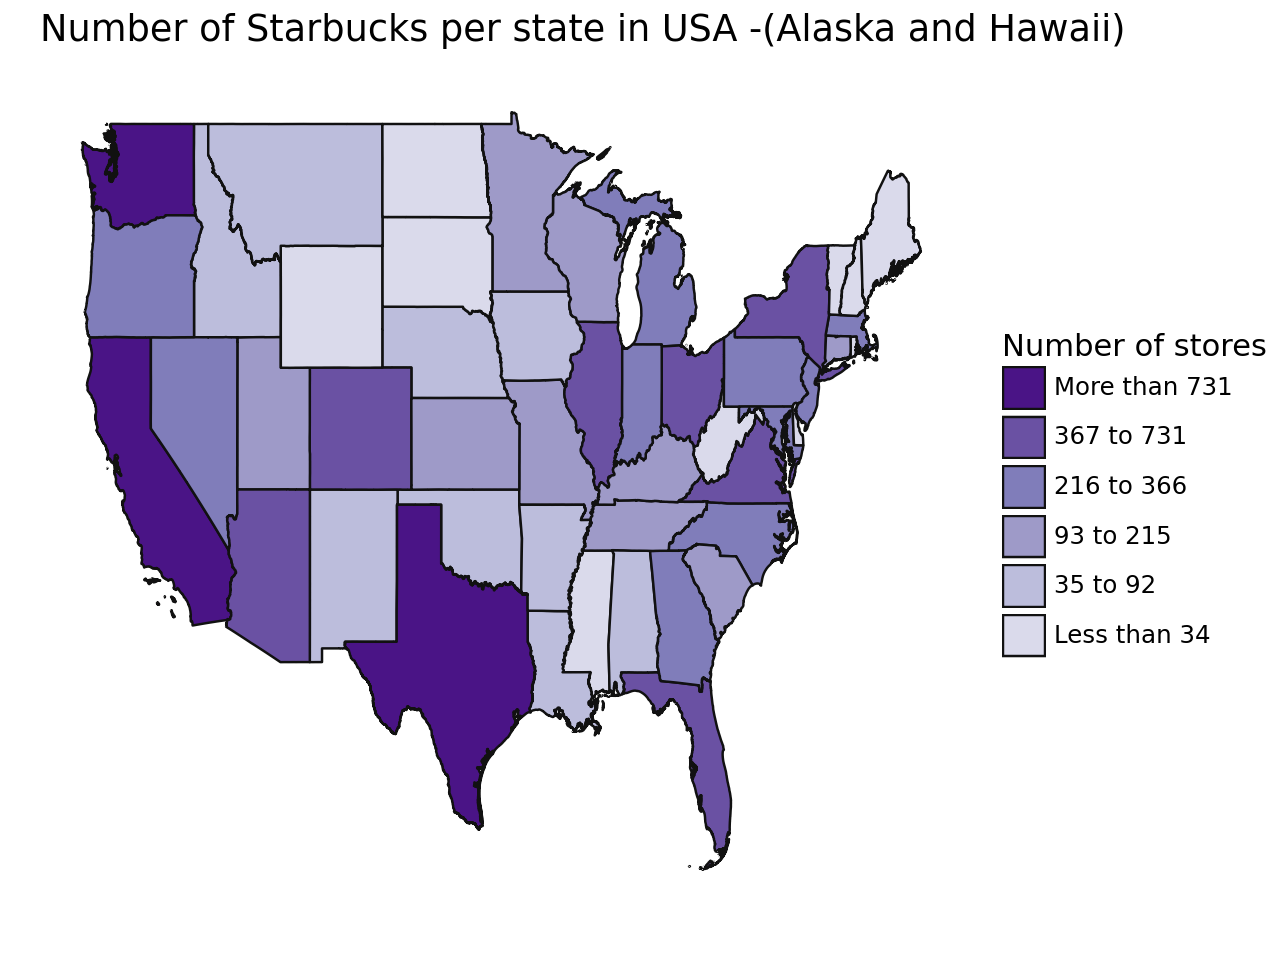

<Figure Size: (640 x 480)>

In [9]:
# Let us play around a bit with different color-schemes 
quantile_val = np.quantile(us_stores_statewise["Count"], [0.2, 0.4, 0.6, 0.8, 0.95])

conditions = [us_stores_statewise["Count"].lt(quantile_val[0]), 
              (us_stores_statewise["Count"].ge(quantile_val[0]) & us_stores_statewise["Count"].lt(quantile_val[1])), 
              (us_stores_statewise["Count"].ge(quantile_val[1]) & us_stores_statewise["Count"].lt(quantile_val[2])), 
              (us_stores_statewise["Count"].ge(quantile_val[2]) & us_stores_statewise["Count"].lt(quantile_val[3])), 
              (us_stores_statewise["Count"].ge(quantile_val[3]) & us_stores_statewise["Count"].lt(quantile_val[4])), 
              us_stores_statewise["Count"].ge(quantile_val[4])]
choices = ["Less than 34", "35 to 92", "93 to 215", "216 to 366", "367 to 731", "More than 731"]
us_stores_statewise["N_stores_quant"] = pd.Categorical(np.select(conditions, choices), 
                                                       categories=choices[::-1])

col_use = ["#dadaeb", "#bcbddc", "#9e9ac8", "#807dba", "#6a51a3", "#4a1486"]
p = (ggplot(us_stores_statewise)
    + geom_map(aes(fill="N_stores_quant"))
    + labs(title = "Number of Starbucks per state in USA -(Alaska and Hawaii)")
    + scale_fill_manual(values=col_use[::-1], name = "Number of stores")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p.save("Figs/Starbuck_bin.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p

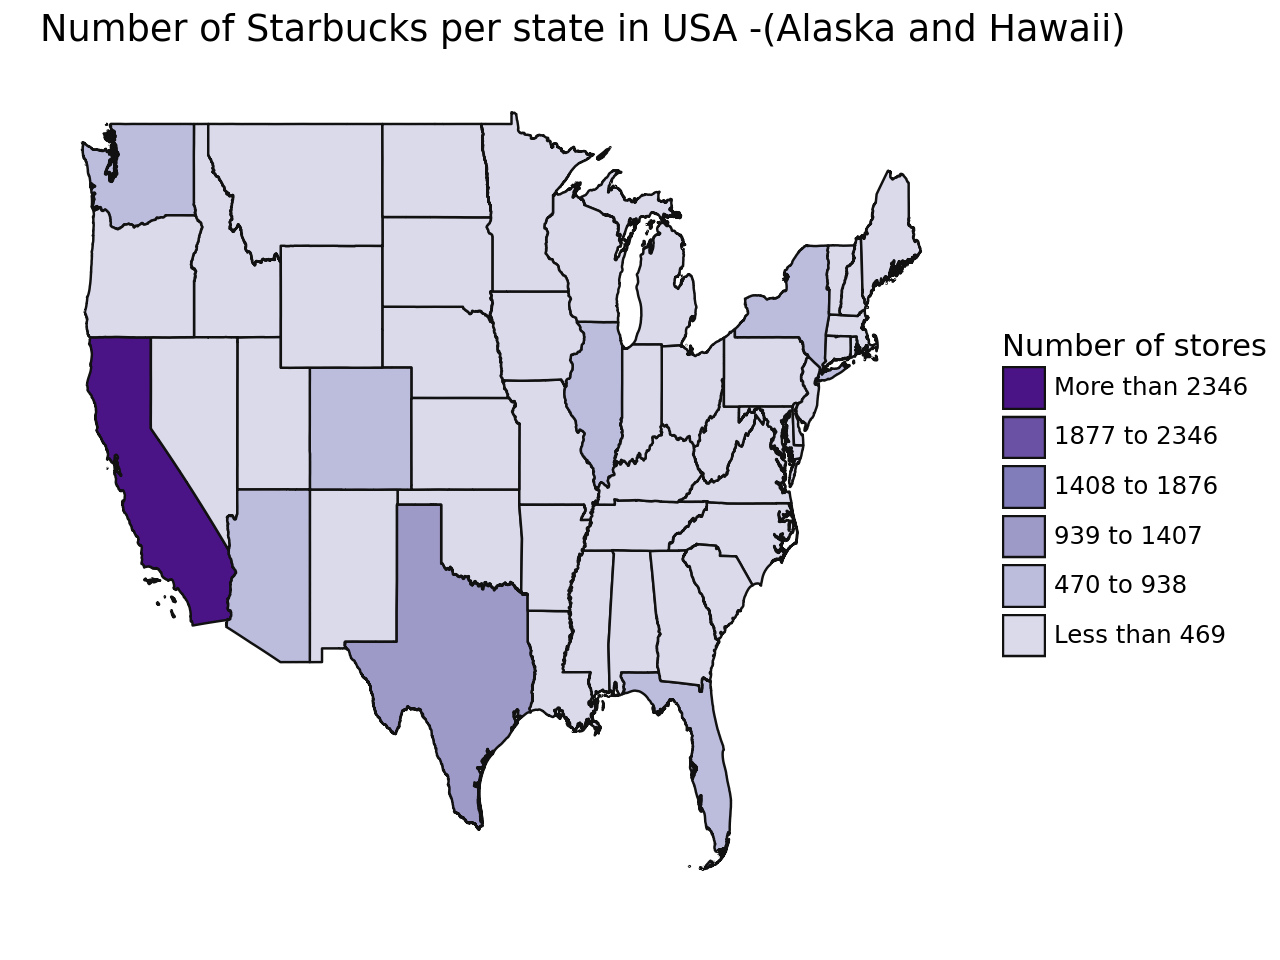

<Figure Size: (640 x 480)>

In [10]:
# Let us play around a bit with different color-schemes and 
# constant equal size for bins
max_val = np.max(us_stores_statewise["Count"])
min_val = np.min(us_stores_statewise["Count"])
class_size = (max_val - min_val) / 6
class_size

conditions = [us_stores_statewise["Count"].lt(class_size*1), 
              (us_stores_statewise["Count"].ge(class_size*1) & us_stores_statewise["Count"].lt(class_size*2)), 
              (us_stores_statewise["Count"].ge(class_size*2) & us_stores_statewise["Count"].lt(class_size*3)), 
              (us_stores_statewise["Count"].ge(class_size*3) & us_stores_statewise["Count"].lt(class_size*4)), 
              (us_stores_statewise["Count"].ge(class_size*4) & us_stores_statewise["Count"].lt(class_size*5)), 
              (us_stores_statewise["Count"].ge(class_size*5) & us_stores_statewise["Count"].lt(class_size*6.5))]
choices = ["Less than 469", "470 to 938", "939 to 1407", "1408 to 1876", "1877 to 2346", "More than 2346"]
us_stores_statewise["N_stores_quant"] = pd.Categorical(np.select(conditions, choices), 
                                                       categories=choices[::-1])

col_use = ["#dadaeb", "#bcbddc", "#9e9ac8", "#807dba", "#6a51a3", "#4a1486"]
p = (ggplot(us_stores_statewise)
    + geom_map(aes(fill="N_stores_quant"))
    + labs(title = "Number of Starbucks per state in USA -(Alaska and Hawaii)")
    + scale_fill_manual(values=col_use[::-1], name = "Number of stores")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p.save("Figs/Starbuck_bin_constant.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p

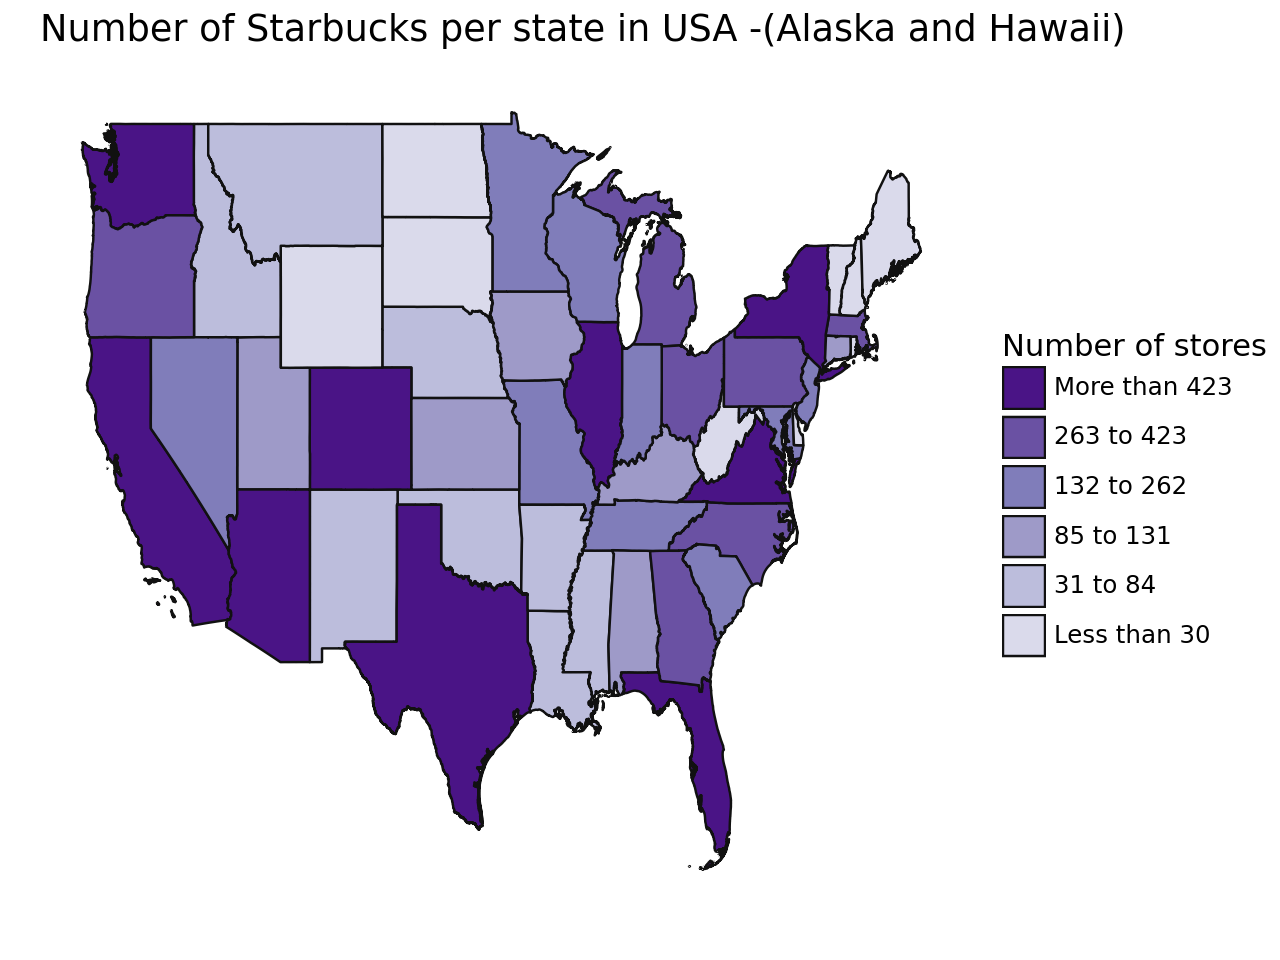

<Figure Size: (640 x 480)>

In [11]:
# Let us play around a bit with different colour schemes, and now use 
# the same number of elements in each class
quantile_val = np.quantile(us_stores_statewise["Count"], [0.17, 0.34, 0.5, 0.67, 0.83])

conditions = [us_stores_statewise["Count"].lt(quantile_val[0]), 
              (us_stores_statewise["Count"].ge(quantile_val[0]) & us_stores_statewise["Count"].lt(quantile_val[1])), 
              (us_stores_statewise["Count"].ge(quantile_val[1]) & us_stores_statewise["Count"].lt(quantile_val[2])), 
              (us_stores_statewise["Count"].ge(quantile_val[2]) & us_stores_statewise["Count"].lt(quantile_val[3])), 
              (us_stores_statewise["Count"].ge(quantile_val[3]) & us_stores_statewise["Count"].lt(quantile_val[4])), 
              us_stores_statewise["Count"].ge(quantile_val[4])]
choices = ["Less than 30", "31 to 84", "85 to 131", "132 to 262", "263 to 423", "More than 423"]
us_stores_statewise["N_stores_quant"] = pd.Categorical(np.select(conditions, choices), 
                                                       categories=choices[::-1])

col_use = ["#dadaeb", "#bcbddc", "#9e9ac8", "#807dba", "#6a51a3", "#4a1486"]
p = (ggplot(us_stores_statewise)
    + geom_map(aes(fill="N_stores_quant"))
    + labs(title = "Number of Starbucks per state in USA -(Alaska and Hawaii)")
    + scale_fill_manual(values=col_use[::-1], name = "Number of stores")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p.save("Figs/Starbuck_quantile_bin.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p

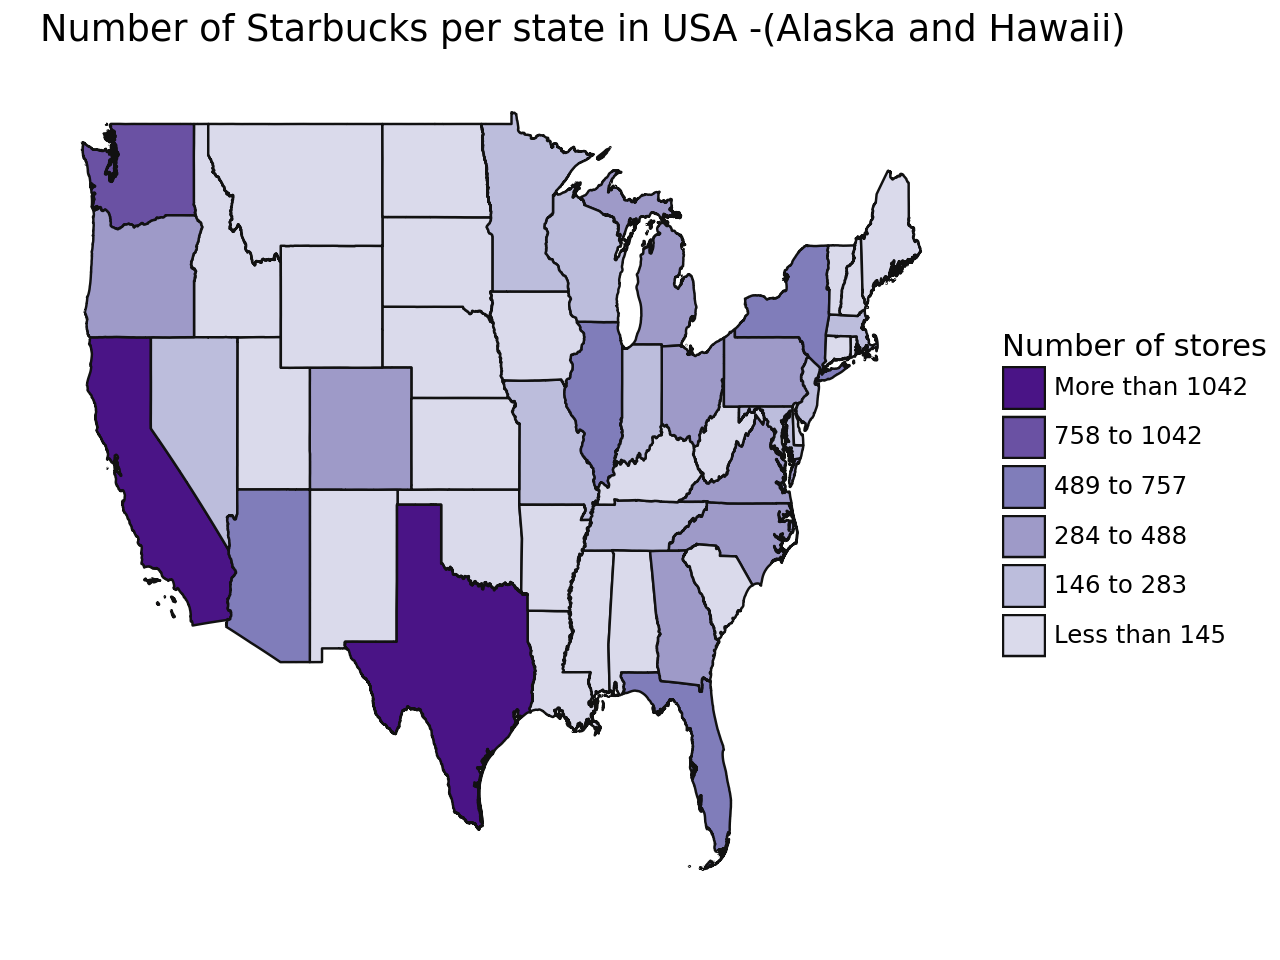

<Figure Size: (640 x 480)>

In [12]:
# Let us play around a bit with different colour schemes, and now use 
# Jenks algorithm
quantile_val = np.quantile(us_stores_statewise["Count"], [0.17, 0.34, 0.5, 0.67, 0.83])

conditions = [us_stores_statewise["Count"].lt(145), 
              (us_stores_statewise["Count"].ge(145) & us_stores_statewise["Count"].lt(283)), 
              (us_stores_statewise["Count"].ge(283) & us_stores_statewise["Count"].lt(488)), 
              (us_stores_statewise["Count"].ge(488) & us_stores_statewise["Count"].lt(757)), 
              (us_stores_statewise["Count"].ge(757) & us_stores_statewise["Count"].lt(1042)), 
              (us_stores_statewise["Count"].ge(1042) & us_stores_statewise["Count"].lt(2900))]
choices = ["Less than 145", "146 to 283", "284 to 488", "489 to 757", "758 to 1042", "More than 1042"]
us_stores_statewise["N_stores_quant"] = pd.Categorical(np.select(conditions, choices), 
                                                       categories=choices[::-1])

col_use = ["#dadaeb", "#bcbddc", "#9e9ac8", "#807dba", "#6a51a3", "#4a1486"]
p = (ggplot(us_stores_statewise)
    + geom_map(aes(fill="N_stores_quant"))
    + labs(title = "Number of Starbucks per state in USA -(Alaska and Hawaii)")
    + scale_fill_manual(values=col_use[::-1], name = "Number of stores")
    + theme(panel_background=element_rect(fill = "white"), 
            axis_ticks=element_blank(), 
            axis_text=element_blank()))

p.save("Figs/Starbuck_jenks_bin.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p

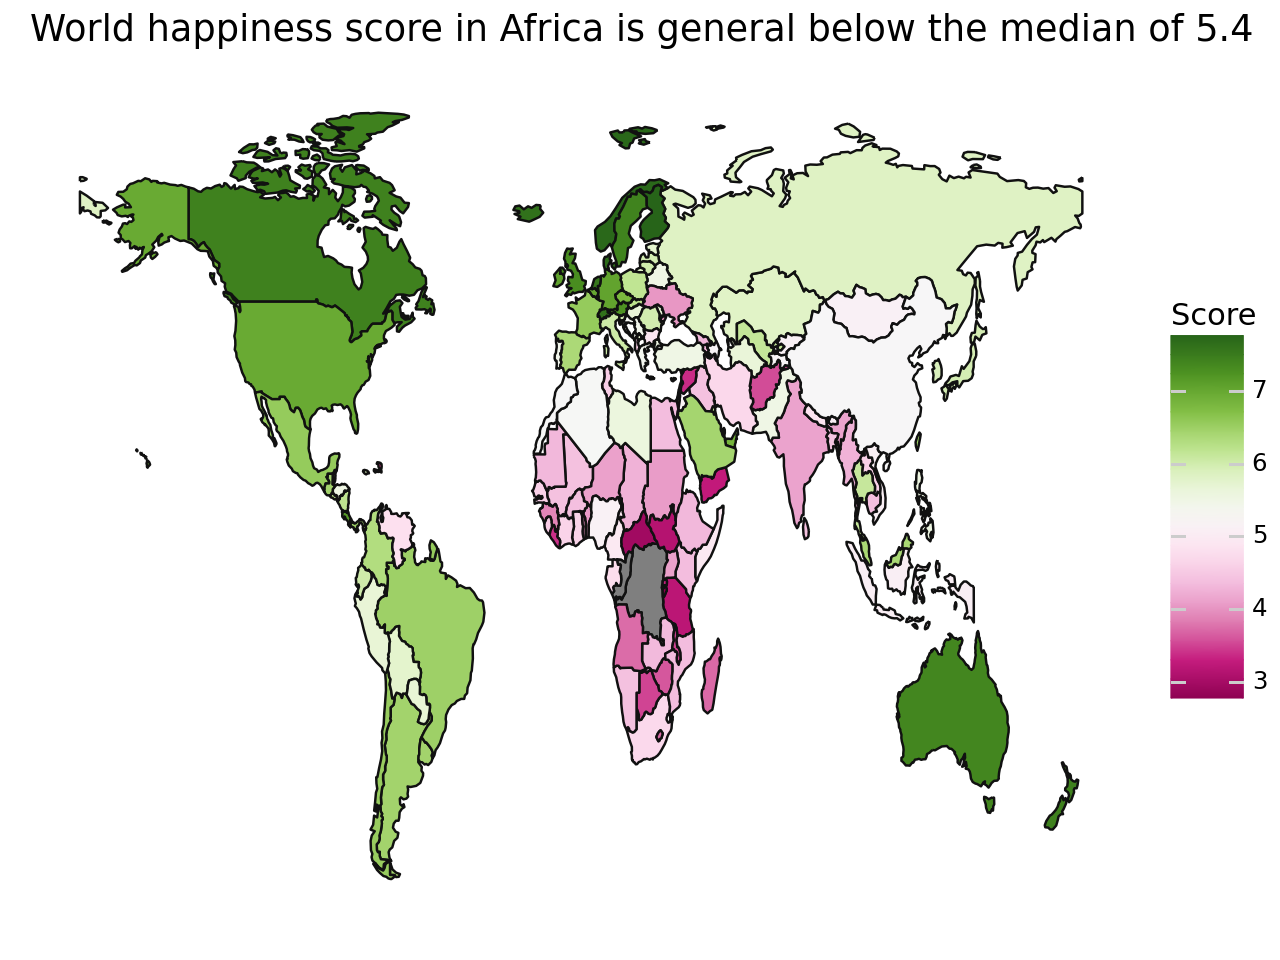

<Figure Size: (640 x 480)>

In [13]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world["name"][world["name"] == "Czechia"] = "Czech Republic"
world["name"][world["name"] == "Dem. Rep. Congo"] = "Congo (Brazzaville)"
world["name"][world["name"] == "Congo"] = "Congo (Kinshasa)"
world["name"][world["name"] == "Central African Rep."] = "Central African Republic"
world["name"][world["name"] == "S. Sudan"] = "South Sudan"
world["name"][world["name"] == "Côte d'Ivoire"] = "Ivory Coast"
world_happiness = pd.read_csv("../Lecture3/Data/2018.csv")
world_happiness["Score"][world_happiness["Country or region"] == "Congo (Kinshasa)"] = np.nan
world_happiness["Score"][world_happiness["Country or region"] == "Congo (Brazzaville)"] = np.nan
new_row = pd.DataFrame({"Overall rank" : 1000, "Country or region": "United States of America", "Score" : 6.89, "GDP per capita": 1e9}, index=[0]) # Somehow USA in not in the data
world_happiness = pd.concat([world_happiness, new_row])
world_total_data = world.merge(world_happiness, left_on="name", right_on="Country or region")

p1 = (ggplot(world_total_data, aes(fill="Score"))
    + geom_map()
    + labs(title="World happiness score in Africa is general below the median of 5.4")
    + scale_fill_cmap("PiYG")
    + theme_void())

p1.save("Figs/Map_happy_better.png", width=BASE_WIDTH, height=BASE_HEIGHT, dpi=300)
p1